# Timeseries data

In the current notebook, we will explore some of the nuances of the 'timeseries' dataset.  
This notebook will expand the EDA process for the individual datasets, focusing on investigating the interaction between different variables.  

The 'timeseries' dataset consists of the historical data of products orders. We track some measures like stocks, prices, competitor's prices, shipping values, order quantities over time, for 644 different products.

## TABLE OF CONTENTS

0. [Library and data imports](#library)  
1. [Dataset Exploration](#exploration)  
    1.1 Headers  
    1.2 Data types  
    1.3 Missing Values  
    1.4 Artificial columns  
    1.5 Summary statistics  
2. [Univariate Analysis](#univariate)  
    2.1 Prices (olist, competition, deltas)  
    2.2 Shipping (freight ratio)  
    2.3 Product attributes (types and groups)  
    2.4 Orders  
3. [Bivariate Analysis](#bivariate)  
    3.1 Price x Orders  
    3.2 Shipping x Orders  
    3.3 Product Attributes x Orders  
4. [Demand Sparsity](#sparsity)  
    4.1 Demonstrate sparsity of sales inside product_groups and types; show that we have few gtins per category  
5. [Product Group Analysis](#group)  
6. [Product GTIN analysis](#gtin)  
    6.1 Makeup Kit  

<a name="library"></a>
### 0 - Imports and reading the data

Let's import some packages and read the data.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
#import cufflinks as cf

#from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
#from IPython.core.display import display, HTML
#from pandas_profiling import ProfileReport

In [28]:
# setup
#display(HTML("<style>.container { width:35% !important; } .widget-select > select {background-color: gainsboro;}</style>"))
#init_notebook_mode(connected=True)
pd.set_option('display.max_columns', None)

#plt.rcParams['figure.dpi']= 440
plt.style.use('ggplot')

In [3]:
#df = pd.read_csv('https://bsa-correlation-one.s3.amazonaws.com/timeseries644.csv')
df = pd.read_csv('../data/timeseries644.csv', dtype={'product_gtin':'str'})

<a name="exploration"></a>
### 1. Dataset exploration

At first, let's explore a few of the dataset's attributes. It is important to understand some of the column's information, data types, missing values and major statistics.


#### 1.1 Dataset Headers:

Each row of the dataset consists of the following information, for a given date: a product (gtin), the competition price and olist's price, the commission rates, the number of sales (orders), the product type and group, stock information and product's name and description.

In [4]:
df.head(3)

,date,product_gtin,competition_price,price,freight_value,commission_product_olist,commission_freight_olist,orders,product_type,product_type_group,stock_max,stock_min,stock_avg,price_max,price_min,price_avg,offer_max,offer_min,offer_avg,name,description
0,2016-10-03,7909389107160,169.9,179.9,NaN,NaN,NaN,0.0,Prato giratório,utilidades_domesticas,0.0,0.0,0.0,179.9,179.9,179.9,179.9,179.9,179.9,Prato Giratório 80 cm em Madeira Laminado,Prato Giratório para Mesa Sala de Jantar;\nDim...
1,2016-10-04,7909389107160,169.9,179.9,NaN,NaN,NaN,0.0,Prato giratório,utilidades_domesticas,0.0,0.0,0.0,179.9,179.9,179.9,179.9,179.9,179.9,Prato Giratório 80 cm em Madeira Laminado,Prato Giratório para Mesa Sala de Jantar;\nDim...
2,2016-10-05,7909389107160,169.9,179.9,NaN,NaN,NaN,0.0,Prato giratório,utilidades_domesticas,0.0,0.0,0.0,179.9,179.9,179.9,179.9,179.9,179.9,Prato Giratório 80 cm em Madeira Laminado,Prato Giratório para Mesa Sala de Jantar;\nDim...


#### 1.2 Dataset info:

We have 299941 rows, with 21 columns. Most of the columns are complete, but notice that freight_value and commission columns have only 6.26% of the rows with information (18875). This information is only available when orders were created for a given product, on any given day.  
Also, product_type and group are present in 71.4% of the rows (214135). This means that roughly 30% of the products were not being sold in 1Q of 2020, when the categorization system was created.

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 299941 entries, 0 to 299940
Data columns (total 21 columns):
 #   Column                    Non-Null Count   Dtype  
---  ------                    --------------   -----  
 0   date                      299941 non-null  object 
 1   product_gtin              299941 non-null  object 
 2   competition_price         299941 non-null  float64
 3   price                     299941 non-null  float64
 4   freight_value             18775 non-null   float64
 5   commission_product_olist  18775 non-null   float64
 6   commission_freight_olist  18775 non-null   float64
 7   orders                    299941 non-null  float64
 8   product_type              214135 non-null  object 
 9   product_type_group        214135 non-null  object 
 10  stock_max                 299941 non-null  float64
 11  stock_min                 299941 non-null  float64
 12  stock_avg                 299941 non-null  float64
 13  price_max                 299941 non-null  f

#### 1.3 Missing values:

We can observe that freight value (which is the amount of shipping that was paid by the final customer) and commission_values are missing. Those columns will be dealt with later.

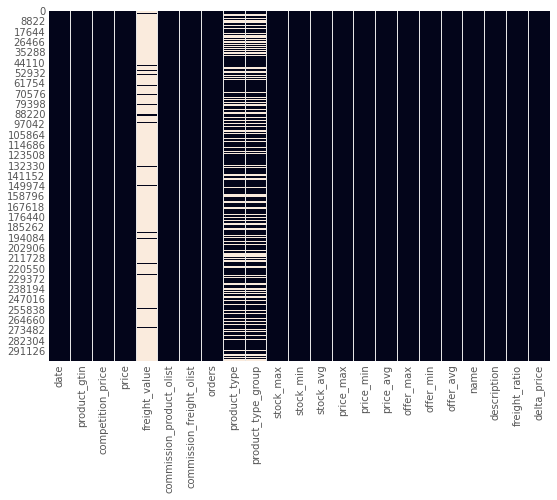

In [29]:
plt.figure(figsize=(8,6))
sns.heatmap(df.isnull(), cbar=False)
plt.show()

#### 1.4 Artificial columns and missing values:

Let's fill the empty values when needed and create some other columns that might be interesting to our analysis.  

Missing values:
- commissions: The empty commission rows will be filled with 0.20, since it is olist's default commision.

Artificial columns:
- freight_ratio: the ratio between shipping prices and the product's value. This might be problematic for product's that did not have any sales. For now, we will fill empty rows with the mean of other rows. This could be solved in a few weeks, since olist is preparing its shipping quotes historical database.  
- delta_price: percentual price difference between olist's price and competitor's price.

In [15]:
# Missing Values:

df[['commission_product_olist','commission_freight_olist']] = df[['commission_product_olist','commission_freight_olist']].fillna(value=0.20)

In [20]:
# Artificial columns:

### Freight ratio:
def freight_ratio(row):
    shipping = row['freight_value']
    price = row['price']
    if np.isnan(shipping):
        ratio = np.nan
    else:
        ratio = round(shipping / price, 3)
    
    return ratio


df['freight_ratio'] = df.apply(freight_ratio, axis=1)
df['freight_ratio'] = df.freight_ratio.fillna(value=df.freight_ratio.mean())


### Delta price
df['delta_price'] = (df.price.values / df.competition_price.values) - 1

In [21]:
df.head()

,date,product_gtin,competition_price,price,freight_value,commission_product_olist,commission_freight_olist,orders,product_type,product_type_group,stock_max,stock_min,stock_avg,price_max,price_min,price_avg,offer_max,offer_min,offer_avg,name,description,freight_ratio,delta_price
0,2016-10-03,7909389107160,169.9,179.9,NaN,0.2,0.2,0.0,Prato giratório,utilidades_domesticas,0.0,0.0,0.0,179.9,179.9,179.9,179.9,179.9,179.9,Prato Giratório 80 cm em Madeira Laminado,Prato Giratório para Mesa Sala de Jantar;\nDim...,0.294889,0.058858
1,2016-10-04,7909389107160,169.9,179.9,NaN,0.2,0.2,0.0,Prato giratório,utilidades_domesticas,0.0,0.0,0.0,179.9,179.9,179.9,179.9,179.9,179.9,Prato Giratório 80 cm em Madeira Laminado,Prato Giratório para Mesa Sala de Jantar;\nDim...,0.294889,0.058858
2,2016-10-05,7909389107160,169.9,179.9,NaN,0.2,0.2,0.0,Prato giratório,utilidades_domesticas,0.0,0.0,0.0,179.9,179.9,179.9,179.9,179.9,179.9,Prato Giratório 80 cm em Madeira Laminado,Prato Giratório para Mesa Sala de Jantar;\nDim...,0.294889,0.058858
3,2016-10-06,7909389107160,169.9,179.9,NaN,0.2,0.2,0.0,Prato giratório,utilidades_domesticas,0.0,0.0,0.0,179.9,179.9,179.9,179.9,179.9,179.9,Prato Giratório 80 cm em Madeira Laminado,Prato Giratório para Mesa Sala de Jantar;\nDim...,0.294889,0.058858
4,2016-10-07,7909389107160,169.9,179.9,NaN,0.2,0.2,0.0,Prato giratório,utilidades_domesticas,0.0,0.0,0.0,179.9,179.9,179.9,179.9,179.9,179.9,Prato Giratório 80 cm em Madeira Laminado,Prato Giratório para Mesa Sala de Jantar;\nDim...,0.294889,0.058858


#### 1.5 Summary Statistics:

From the summary statistics table below, we can observe a few interesting patterns:  
- For olist and competition prices, we observe similar values for every statistic.  
- For commisions (over products and freight value), we see a similar mean and quartiles values. Olist's default commision is set to 0.20.  
- The orders column, which may be the most important for our analysis, we notice that most of the days have zero orders. This indicates a significant sparsity in our orders.
- For delta price, we observe that olist's price is, on average, 3% higher than its competitors'. One major issue with the data gathering process is that some of the competitor's prices are olist's prices itself. This happens when olist is the only vendor for a given product, or has the lowest price in the marketplace.

In [30]:
df.describe().round(2)

,competition_price,price,freight_value,commission_product_olist,commission_freight_olist,orders,stock_max,stock_min,stock_avg,price_max,price_min,price_avg,offer_max,offer_min,offer_avg,freight_ratio,delta_price
count,299941.00,299941.00,18775.00,299941.00,299941.00,299941.00,299941.00,299941.00,299941.00,299941.00,299941.00,299941.00,299941.00,299941.00,299941.00,299941.00,299941.00
mean,225.83,230.60,21.43,0.20,0.20,0.14,947.99,781.91,866.69,259.58,256.31,258.45,232.73,228.59,230.71,0.29,0.03
std,385.85,397.31,18.14,0.00,0.01,1.00,11724.94,11062.90,11301.07,433.64,430.36,432.76,401.33,393.73,397.47,0.06,0.15
min,6.99,6.97,0.00,0.09,0.00,0.00,0.00,0.00,0.00,6.99,6.99,6.99,6.99,6.92,6.97,0.00,-0.87
25%,65.00,65.00,12.16,0.20,0.20,0.00,5.00,1.00,4.00,79.00,76.80,78.47,65.81,64.99,65.00,0.29,0.00
50%,129.99,134.90,18.12,0.20,0.20,0.00,14.00,5.00,11.38,150.64,150.00,150.00,137.99,134.00,134.90,0.29,0.00
75%,239.90,240.00,25.08,0.20,0.20,0.00,99.00,80.00,97.00,288.80,279.99,282.00,243.99,239.99,240.00,0.29,0.01
max,7406.30,7387.78,344.70,0.25,0.25,91.00,246225.00,246225.00,246225.00,7406.30,7406.30,7406.30,7406.30,7332.24,7387.78,3.29,5.07


<a name="univariate"></a>
### 2. Univariate analysis

We now explore some of our variables behaviours, most notably:  
- prices (competitor's, olist's and delta)
- shipping values (freight_values and freight_ratio)
- product types and groups (categorical)
- orders

#### 2.1 Prices

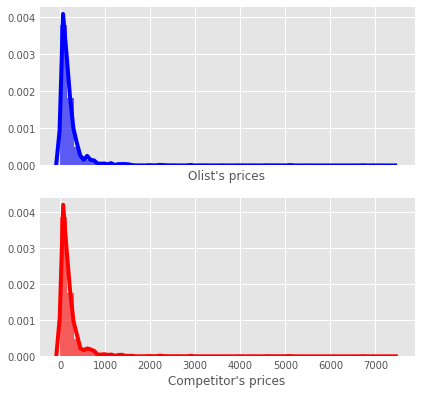

In [83]:
fig, ax = plt.subplots(nrows=2, figsize=(6, 6), sharex=True)

sns.distplot(df.price, hist=True, kde=True, color='blue', hist_kws=dict(alpha=0.6), ax=ax[0])
ax[0].set_xlabel("Olist's prices")

sns.distplot(df.competition_price, hist=True, kde=True, color='red', hist_kws=dict(alpha=0.6), ax=ax[1])
ax[1].set_xlabel("Competitor's prices")

# sns.distplot(df.delta_price, hist=True, kde=True, color='green', hist_kws=dict(alpha=0.6), ax=ax[2])
# ax[2].set_xlim((-0.25,0.25))
# ax[2].set_xlabel("Delta prices")

plt.show()

<a name="bivariate"></a>
### 3. Bivariate Analysis

Our main focus of this EDA is to understand what drives order quantities.  
1. Freight Value (how does free shipping impact our sales)  
2. Relationship to competitor's prices

Let's create 2 different columns to map some relationships between variables:  

- delta_price: price difference (%) between olist's price and our competition's price;
- freight_ratio: ratio between freight value and product's price. When freight_value is NaN, it will be assumed as 16%

In [ ]:
df['delta_price'] = (df.price.values / df.competition_price.values) - 1

In [ ]:
def freight_ratio(row):
    shipping = row['freight_value']
    price = row['price']
    if np.isnan(shipping):
        ratio = 0.20
    else:
        ratio = round(shipping / price, 3)
    
    return ratio

In [ ]:
df['freight_ratio'] = df.apply(freight_ratio, axis=1)

Now, let's see how orders are correlated with other variables

In [ ]:
df.corr()[['orders']]

Interestingly, freight_ratio is weakly positively correlated with order quantities. We expected to see a negative correlation between those values, meaning that orders go up when shipping prices are low (free shipping).  
  
Analyzing delta_prices, we see a negative correlation, but we have some data quality limitations. When capturing the competitor's prices, olist is actually gathering information about the cheapest price of a product on one specific marketplace (b2w). If olist has the market's best price, the 'competition_price' is filled with olist's price most of the times. 

In [ ]:
df.delta_price.describe()

In [ ]:
sns.distplot(df.delta_price.values)
plt.xlim((-1,2))

<a name="sparsity"></a>
### 4. Demand sparsity

Olist offers many long-tail products, i.e. hard to find products, that are sold in low volumes to many customers. To mitigate this problem, let's first analyze the top selling products/categories.

##### Products

In [ ]:
df['days'] = 1

In [ ]:
sparsity = df.groupby('product_gtin')[['orders','days']].sum().reset_index()

sparsity['orders_per_day'] = sparsity['orders'].values / sparsity['days'].values

sparsity = sparsity.sort_values(by=['orders','orders_per_day'], ascending=False).reset_index(drop=True)

sparsity.describe()

In [ ]:
fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(12,8))
sns.distplot(sparsity.orders, ax=ax[0][0])
sns.distplot(sparsity.orders_per_day, ax=ax[0][1])

sns.boxplot(sparsity.orders, ax=ax[1][0])
sns.boxplot(sparsity.orders_per_day, ax=ax[1][1])

##### Product types

In [ ]:
sparsity_ty = df.groupby('product_type')[['orders','days']].sum().reset_index()

sparsity_ty['orders_per_day'] = sparsity_ty['orders'].values / sparsity_ty['days'].values

sparsity_ty = sparsity_ty.sort_values(by=['orders','orders_per_day'], ascending=False).reset_index(drop=True)

sparsity_ty.describe()

In [ ]:
sparsity_ty.head(5)

In [ ]:
temp = sparsity_ty.sort_values(by='orders_per_day', ascending=False)

fig, ax = plt.subplots(ncols=2, figsize=(12,8))


sns.barplot(temp.product_type.head(), temp.orders_per_day.head(), ax=ax[0])
sns.barplot(temp.product_type.head(), temp.orders.head(), ax=ax[1])

ax[0].set_xticklabels(temp.product_type.head(),rotation=45)
ax[1].set_xticklabels(temp.product_type.head(),rotation=45)


plt.tight_layout()

plt.show()

##### Product groups

In [ ]:
sparsity_gr = df.groupby('product_type_group')[['orders','days']].sum().reset_index()

sparsity_gr['orders_per_day'] = sparsity_gr['orders'].values / sparsity_gr['days'].values

sparsity_gr = sparsity_gr.sort_values(by=['orders','orders_per_day'], ascending=False).reset_index(drop=True)

sparsity_gr.describe()

In [ ]:
temp = sparsity_gr.sort_values(by='orders_per_day', ascending=False)

fig, ax = plt.subplots(ncols=2, figsize=(12,8))


sns.barplot(temp.product_type_group.head(), temp.orders_per_day.head(), ax=ax[0])
sns.barplot(temp.product_type_group.head(), temp.orders.head(), ax=ax[1])

ax[0].set_xticklabels(temp.product_type_group.head(),rotation=45)
ax[1].set_xticklabels(temp.product_type_group.head(),rotation=45)


plt.tight_layout()

plt.show()

<a name="group"></a>
### 5. Product Groups

#### TODO

<a name="gtin"></a>
### 6. GTIN Analysis

#### 6.1 Product 1: Make-up kit
Let's choose a single product_type: makeup kit.  
It contains the largest average of orders per day (~5)

In [ ]:
makeup = df[df.product_type == 'Kit maquiagem'].copy().reset_index(drop=True)

In [ ]:
makeup.product_gtin.nunique()

In [ ]:
makeup.info()

In [ ]:
makeup.describe()

In [ ]:
makeup.corr().round(3)[['orders']]

Now, we see that both freight ratio and freight value columns have negative correlations with orders. That could indicate that offering free shipping might have a bigger impact on sales.  
If we observe the delta_price correlation we might consider that having a higher price than our competitors may not hinder our competitiveness.  

Let's analyze our timeseries behaviour:

In [ ]:
makeup = makeup.set_index('date')

In [ ]:
columns = ['competition_price', 'price', 'freight_value','orders', 'stock_max'] 

In [ ]:
iplot([{
    'x': makeup.index,
    'y': makeup[col],
    'name': col
}  for col in columns])

Looking at the above plot, we can observe a few interesting things: the period in which we have the most sales is a few weeks before Christmas; The period without sales from mid December 2019 to January is the same period when our stocks are the lowest (around 5 units); We observe that from Jan 28th to Feb 3, there was a small rise in sales when the shipping values were 0 (free shipping); 

In [ ]:
makeup.name[0]

In [ ]:
makeup.product_gtin[0]